###  Removal of Basis-Set Artifacts in Kohn−Sham Potentials Recovered from Electron Densities 
J. Chem. Theory Comput. 2013, 9, 3959−3964

#### Introduction:

Gaiduk and co-workers investigated that in principle, one should be able to obtain the exchange-correlation potential $v_{xc}(r)$ from a set of canonical orbitals. This could be done by manipulating the Kohn-Sham equations as:


$$
[-\frac{1}{2} \nabla^2 + v_{eff}(r)] \phi_i(r) = \varepsilon_i \phi_i(r)
$$

Where $$veff = v(r) + v_{H}(r) + v_{xc}(r)$$ 

Obtain $v_{xc}(r)$ from:

$$v_{xc}(r) = \frac{1}{n(r)} \sum_i^N [\phi_i^{*} (r) \nabla^2 \phi_i(r) + \varepsilon_i | \phi_i(r)|^2] $$


Such procedure introduces oscillations and asymptotic divergences that have origin in small oscillations in the Kohn-Sham orbitals that are amplified by the Laplacian. 

We can perform such an inversion in $\textit{n2v}$. Let us see how:

In [22]:
#Import modules
import n2v
import psi4
import matplotlib.pyplot as plt
import numpy as np

In [23]:
#Set options within Psi4.
#Saving the jk object prevents n2v to build it again. 
psi4.set_options({"save_jk" : True})

#n2v is driven by psi4's reference option. Make sure you set it accordingly. 
psi4.set_options({"reference" : "rhf"})

#Set memory and avoid inheriting options from a different calculation. 
psi4.set_memory(int(2.50e9))
psi4.core.clean()

In [26]:
#Let us focus on the Neon atom. 

#Define Psi4 geometries. Symmetries need to be set to C1!
Ne = psi4.geometry( 
""" 
0 1
Ne 0.0 0.0 0.0
noreorient
nocom
units bohr
symmetry c1
""" )

#Perform a DFT calculation.
e, wfn = psi4.energy("svwn/6-311G", return_wfn=True, molecule=Ne)

#Define inverter objects for each molcule. Simply use the wnf object from psi4 as an argument. 
ine = n2v.Inverter(wfn)

#Define a grid to visualize all of the generated potentials. 
#Since we are using radially symmetric atoms, we focus on the space from the origin all the way to 10 a.u. 
npoints=10002
x = np.linspace(0,10,npoints)[:,None]
y = np.zeros_like(x)
z = y
grid = np.concatenate((x,y,z), axis=1).T

#Load Quantum Monte Carlo Data
mc_xyz = np.load('../data/ne_xyz.npy')
mc_vxc = np.load('../data/ne_vxc.npy')

In [27]:
### Let us know invert the kohn-sham equations. 
vxc_inverted = ine.invert_kohn_sham_equations(wfn, grid)

#The previous function will generate the appropriatte components on the grid to build the last equation from the introduction. 

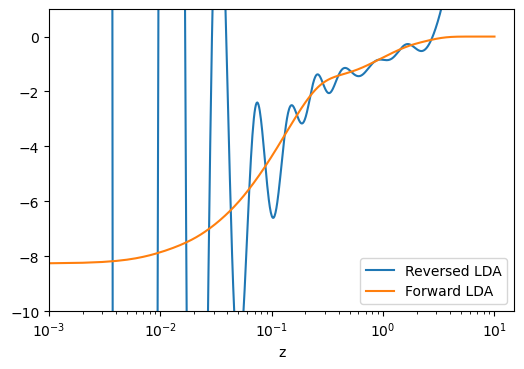

In [31]:
#Compare the performance of direct and reversed calculation of vxc. 

#---------------> Plot
fig, ax = plt.subplots(1,1, dpi=100)


#---------------> Data
ax.plot(x, vxc_inverted, label="Reversed LDA")
ax.plot(x, vxc_0, label="Forward LDA")


#---------------> Formatting
ax.set_xlim(0.001,15)
ax.set_ylim(-10,1)
ax.set_xscale('log')
ax.set_xlabel('z')
ax.legend()

fig.show()


Notice how the potential does follow the correct shape, but it contains spurious features. Gaiduk and Co-workers discovered that these oscillations are purely deterministic and can be used to generate an oscilatory profile that can correct inverted potentials. 

In order to produre an oscillatory profile:

* Run a calculation using the LDA_X functional. 
* Obtain the forward LDA potential. 
* Obtain the reversed LDA potential. 
* Subtract the reversed potential from the forward potential and store the oscillatory profile. 

#This can be simply done in $\textit{n2v}$ with the following:


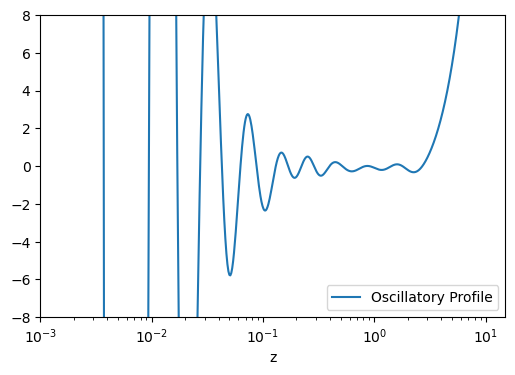

In [32]:
#n2v can obtain the correction with the function:
osc_profile = ine.get_basis_set_correction(grid)

#Let us look at the oscillatory profile. 

#---------------> Plot
fig, ax = plt.subplots(1,1, dpi=100)


#---------------> Data

ax.plot(x, osc_profile, label="Oscillatory Profile")

#---------------> Formatting
ax.set_xlim(0.001,15)
ax.set_ylim(-8,8)
ax.set_xscale('log')
ax.set_xlabel('z')
ax.legend()

fig.show()

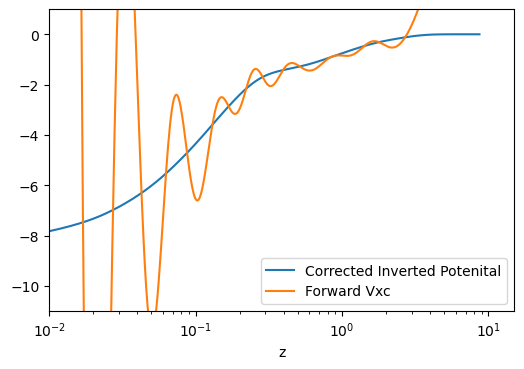

In [34]:
#If we add the previous oscilattory Profile to the svwn calculation, we'll be able to get:

#---------------> Plot
fig, ax = plt.subplots(1,1, dpi=100)

#---------------> Data
ax.plot(x, vxc_inverted - osc_profile, label="Corrected Inverted Potenital")
ax.plot(x, vxc_inverted, label="Forward Vxc")

#---------------> Formatting
ax.set_xlim(0.01,15)
ax.set_ylim(-11,1)
ax.set_xscale('log')
ax.set_xlabel('z')
ax.legend()

fig.show()

Now in this example we corrected LDA, but this correction can be used with any other method as long as the same basis set is being used. Rembember, these oscillations are associated with the basis set and not the method. Let us try again with the scan functional. 

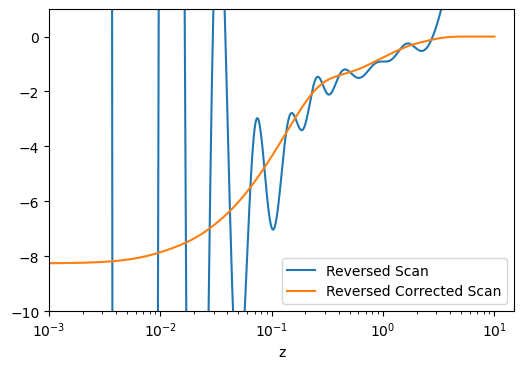

In [38]:
e, wfn_scan = psi4.energy("scan/6-311G", return_wfn=True, molecule=Ne)
vxc_inverted = ine.invert_kohn_sham_equations(wfn_scan, grid)

#And visualize the corrected potential:

#---------------> Plot
fig, ax = plt.subplots(1,1, dpi=100)


#---------------> Data
ax.plot(x, vxc_inverted, label="Reversed Scan")
ax.plot(x, vxc_0, label="Reversed Corrected Scan")

#---------------> Formatting
ax.set_xlim(0.001,15)
ax.set_ylim(-10,1)
ax.set_xscale('log')
ax.set_xlabel('z')
ax.legend()

fig.show()


---
### Let us try a different molecule. 

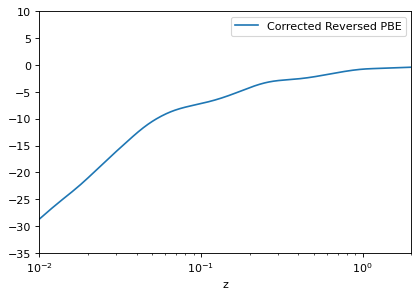

In [20]:
kr = psi4.geometry("""
0 1
Kr 0.0 0.0 0.0
symmetry c1
units angstrom
noreorient
nocom
""")

#Make calculation with any different Funcional
e, wfn_kr = psi4.energy("pbe/6-311G", return_wfn=True, molecule=kr)
ikr = n2v.Inverter(wfn_kr)

#Invert the Kohn-Sham Equations
kr_vxc_inv = ikr.invert_kohn_sham_equations(wfn_kr, grid)
osc_profile = ikr.get_basis_set_correction(grid)

#Compare the performance of direct and reversed calculation of vxc. 
#---------------> Plot
fig, ax = plt.subplots(1,1, dpi=80)


#---------------> Data
ax.plot(x, kr_vxc_inv - osc_profile, label="Corrected Reversed PBE")

#---------------> Formatting
ax.set_xlim(0.01,2)
ax.set_ylim(-35,10)
ax.set_xscale('log')
ax.set_xlabel('z')
ax.legend()

fig.show()


---
### Let us try a calculation with something other than a DFT method. 

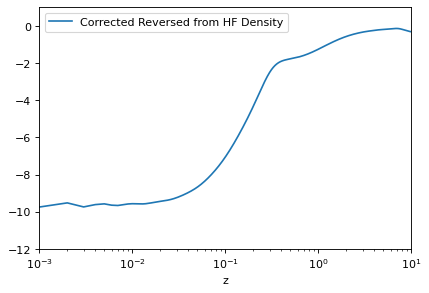

In [45]:
#Calculations are not limited to DFT. Let us try with Hartree Fock:


#Make calculation with any different Funcional
e, wfn_hf = psi4.energy("hf/ugbs", return_wfn=True, molecule=Ne)
iar = n2v.Inverter(wfn_hf)


#Invert the Kohn-Sham Equations
hf_vxc_inv = iar.invert_kohn_sham_equations(wfn_ar, grid)
osc_profile = iar.get_basis_set_correction(grid)

#Compare the performance of direct and reversed calculation of vxc. 


#---------------> Plot
fig, ax = plt.subplots(1,1, dpi=80)

#-------> Data
ax.plot(x, hf_vxc_inv - osc_profile, label="Corrected Reversed from HF Density")

#-------> Formatting
ax.set_xlim(0.001,10)
ax.set_ylim(-12,1)
ax.set_xscale('log')
ax.set_xlabel('z')
ax.legend()

fig.show()